# GWR and GWRF Visualisations

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
%config InlineBackend.figure_format = 'retina'
from mgwr.gwr import GWR
from geo_northarrow import add_north_arrow
from matplotlib_scalebar.scalebar import ScaleBar

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

In [2]:
edinburgh_airbnb_tourism_fs = gpd.read_file('../../data/edinburgh/edinburgh_airbnb_tourism_fs.gpkg')
edinburgh_airbnb_tourism_fs = edinburgh_airbnb_tourism_fs.to_crs(epsg=27700)
# Import Edinburgh GLX shapefile
edinburgh_glx = gpd.read_file("../../data/edinburgh/edinburgh_seamless.gpkg")
edinburgh_glx = edinburgh_glx.to_crs(epsg=27700)

In [3]:
# Merge the correct geometry into the FS dataframe by glx_id
edinburgh_airbnb_tourism_fs = edinburgh_airbnb_tourism_fs.drop(columns='geometry', errors='ignore')

# Rename id to glx_id in edinburgh_glx
edinburgh_glx = edinburgh_glx.rename(columns={'id': 'glx_id'})

edinburgh_airbnb_tourism_fs = edinburgh_airbnb_tourism_fs.merge(
    edinburgh_glx[['glx_id', 'geometry']],
    on='glx_id',
    how='left'
)

# Convert to GeoDataFrame
edinburgh_airbnb_tourism_fs = gpd.GeoDataFrame(edinburgh_airbnb_tourism_fs, geometry='geometry', crs=edinburgh_glx.crs)

## GWR

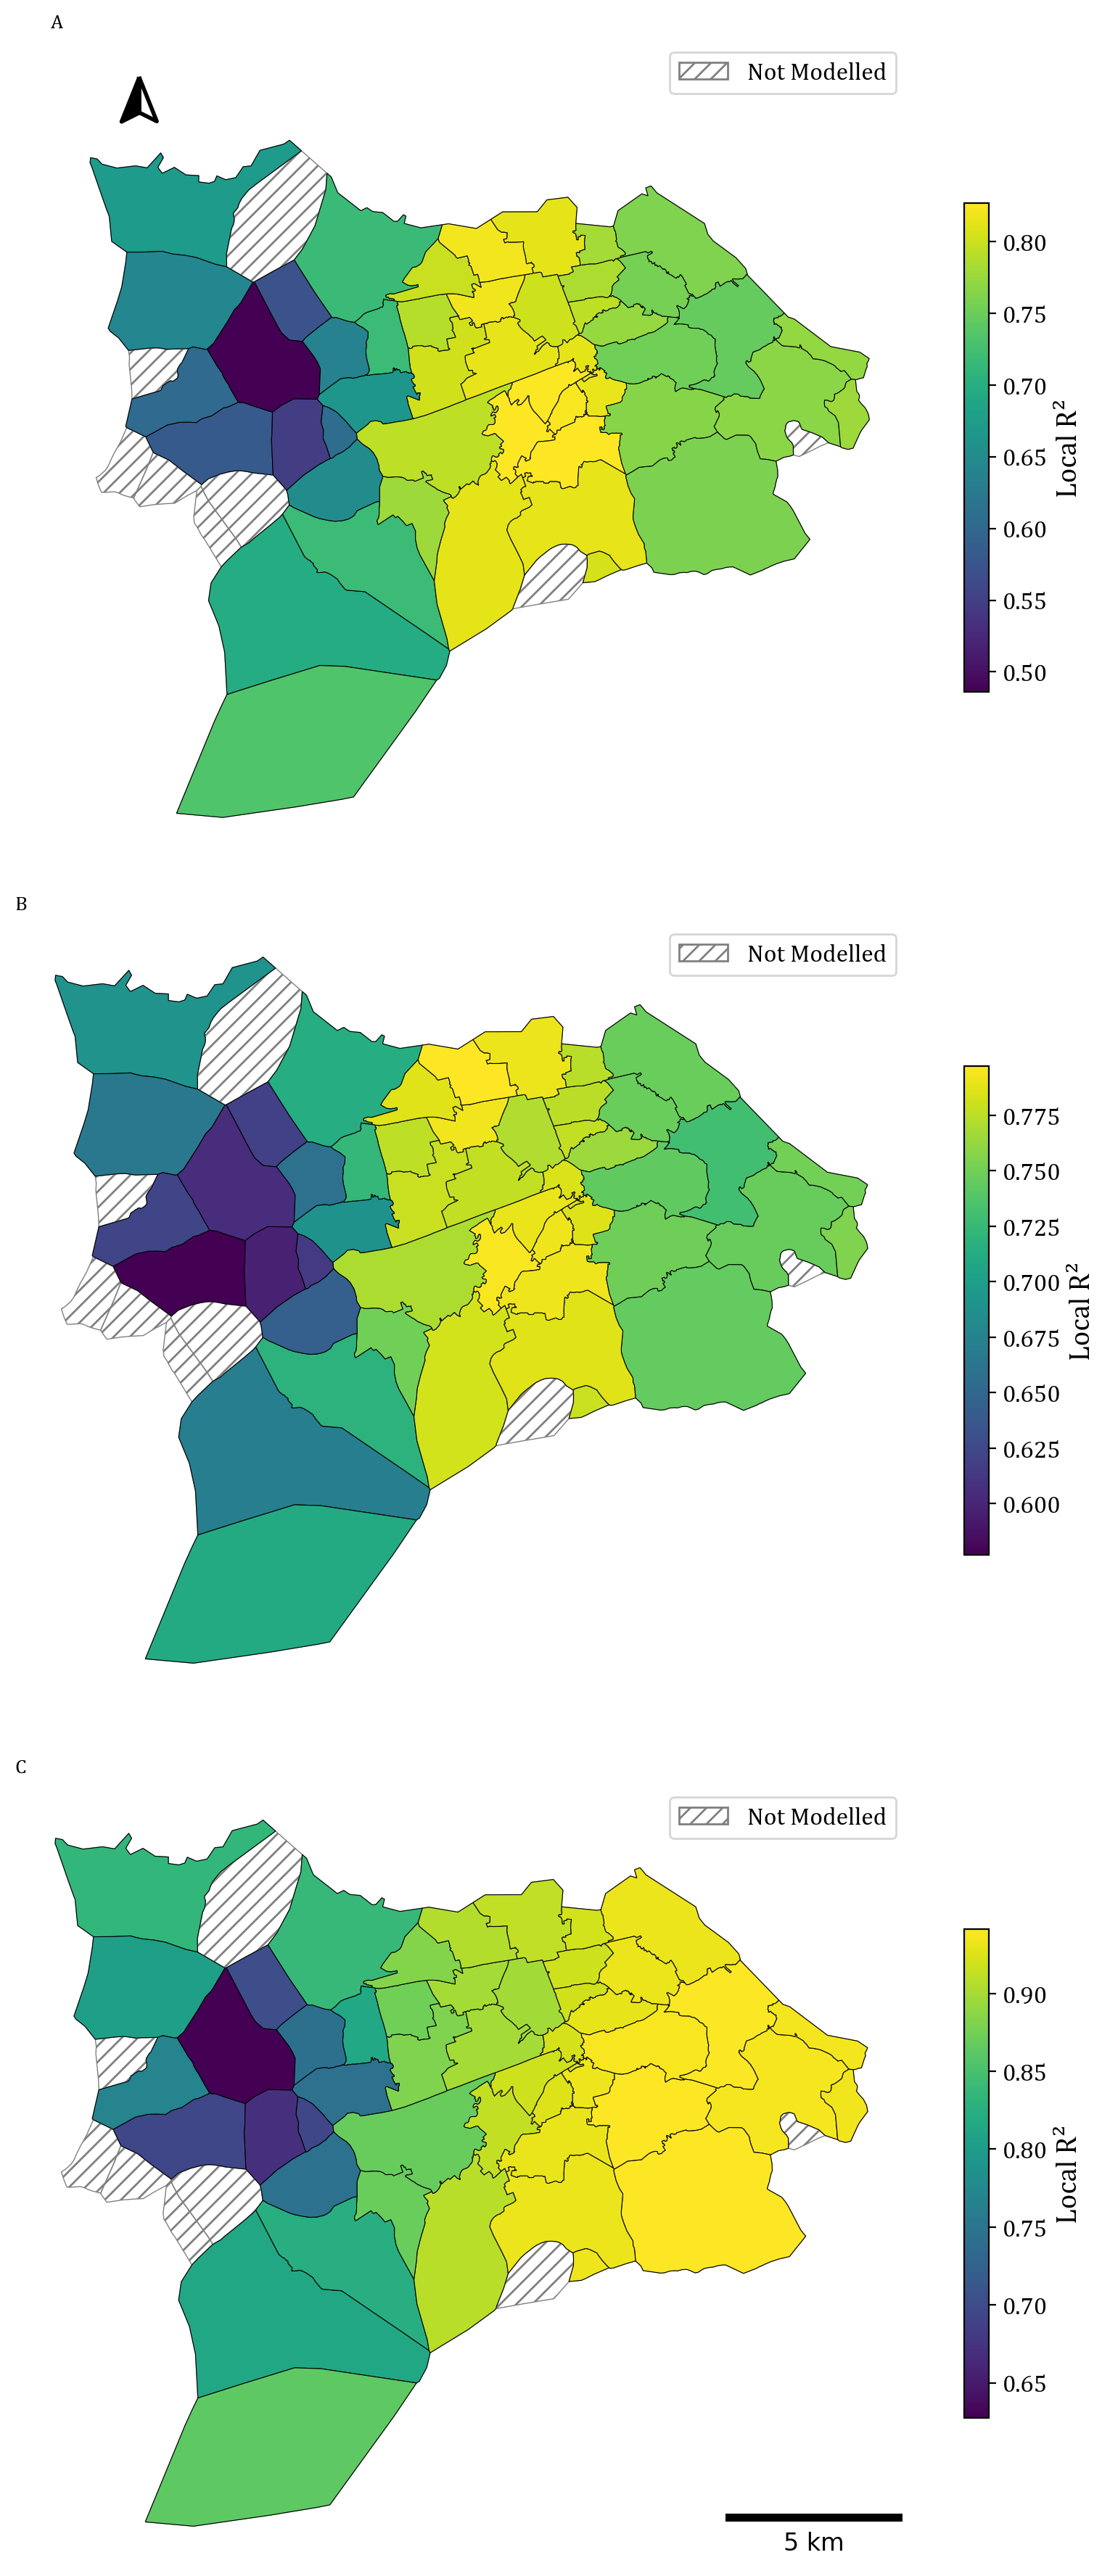

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar

# Map configuration
r2_columns = [
    ("gwr_revenue_local_r2", "A"),
    ("gwr_volume_local_r2", "B"),
    ("gwr_density_local_r2", "C")
]

# Set up figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))  # taller for 3 vertical plots

# Loop through each R² column and plot
for i, (col, title) in enumerate(r2_columns):
    ax = axes[i]
    
    # Filter valid R² rows
    valid_gdf = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs[col].notna()]

    # Base layer: not modelled
    edinburgh_glx.plot(
        ax=ax,
        facecolor="none",
        edgecolor="grey",
        hatch='///',
        linewidth=0.5,
        zorder=0
    )

    # Main choropleth
    r2_map = valid_gdf.plot(
        ax=ax,
        column=col,
        cmap="viridis",
        edgecolor="black",
        linewidth=0.4,
        legend=True,
        legend_kwds={
            'shrink': 0.6,
            'orientation': "vertical",
        },
        zorder=1
    )

    # Colorbar label styling
    cbar = r2_map.get_figure().axes[-1]
    cbar.set_ylabel("Local R²", fontproperties=cambria_prop, fontsize=14)
    for label in cbar.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(12)

    # Legend for hatch (not modelled)
    hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
    legend = ax.legend(handles=[hatch_patch], loc='upper right', fontsize=12)
    legend.get_title().set_fontproperties(cambria_prop)
    for text in legend.get_texts():
        text.set_fontproperties(cambria_prop)
        text.set_fontsize(12)

    # North arrow only on first subplot
    if i == 0:
        add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.980, color='#000', text_scaler=0, text_yT=-1.25)

    # Scale bar only on last subplot
    if i == 2:
        scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
        ax.add_artist(scalebar)

    # Title label (A, B, C)
    ax.set_title(title, fontsize=18, fontproperties=cambria_prop, loc='left')

    # Clean axis
    ax.axis("off")

# Final layout
plt.tight_layout()
plt.show()

## GWRF

In [5]:
# Define the mapping
poi_group_map = {
    'outdoors_other_density_log' : 'Landmarks and Outdoors',
    'retail_other_density_log' : 'Retail',
    'retail_gifts_misc_density_log' : 'Retail',
    'retail_home_electronics_density_log' : 'Retail',
    'local_public_transit_density_log' : 'Travel and Transportation',
    'park_garden_density_log' : 'Landmarks and Outdoors',
    'retail_health_beauty_density_log' : 'Retail',
    'retail_food_beverage_density_log' : 'Retail',
    'fast_food_density_log' : 'Dining and Drinking',
    'cafes_bakeries_density_log' : 'Dining and Drinking',
    'dining_other_density_log' : 'Dining and Drinking',
    'transport_infrastructure_density_log' : 'Travel and Transportation',
    'arts_other_density_log' : 'Arts and Entertainment',
    'full_service_restaurant_density_log' : 'Dining and Drinking',
    'mobility_services_density_log' : 'Travel and Transportation',
    'travel_other_density_log' : 'Travel and Transportation',
    'retail_fashion_apparel_density_log' : 'Retail',
    'tourism_services_density_log' : 'Travel and Transportation',
    'retail_luxury_density_log' : 'Retail',
    'cultural_institution_density_log' : 'Arts and Entertainment',
    'retail_books_hobbies_density_log' : 'Retail',
    'bars_nightlife_density_log' : 'Arts and Entertainment',
    'major_transit_hub_density_log' : 'Travel and Transportation',
    'high_end_dining_density_log' : 'Dining and Drinking',
    'nature_trail_density_log' : 'Landmarks and Outdoors',
    'lodging_density_log' : 'Travel and Transportation',
    'entertainment_nightlife_density_log' : 'Arts and Entertainment',
    'waterfront_river_density_log' : 'Landmarks and Outdoors',
    'historic_landmark_density_log' : 'Landmarks and Outdoors',
    'air_travel_density_log' : 'Travel and Transportation',
    'leisure_activity_centre_density_log' : 'Arts and Entertainment',
    'music_cinema_venue_density_log' : 'Arts and Entertainment',
    'public_art_density_log' : 'Arts and Entertainment',
    'retail_markets_plazas_density_log' : 'Retail',
    'rural_agricultural_density_log' : 'Landmarks and Outdoors',
    'major_attraction_density_log' : 'Arts and Entertainment',
    'public_plaza_square_density_log' : 'Landmarks and Outdoors',
    'food_drink_production_density_log' : 'Dining and Drinking',
    'event_space_density_log' : 'Arts and Entertainment'
}

### Revenue

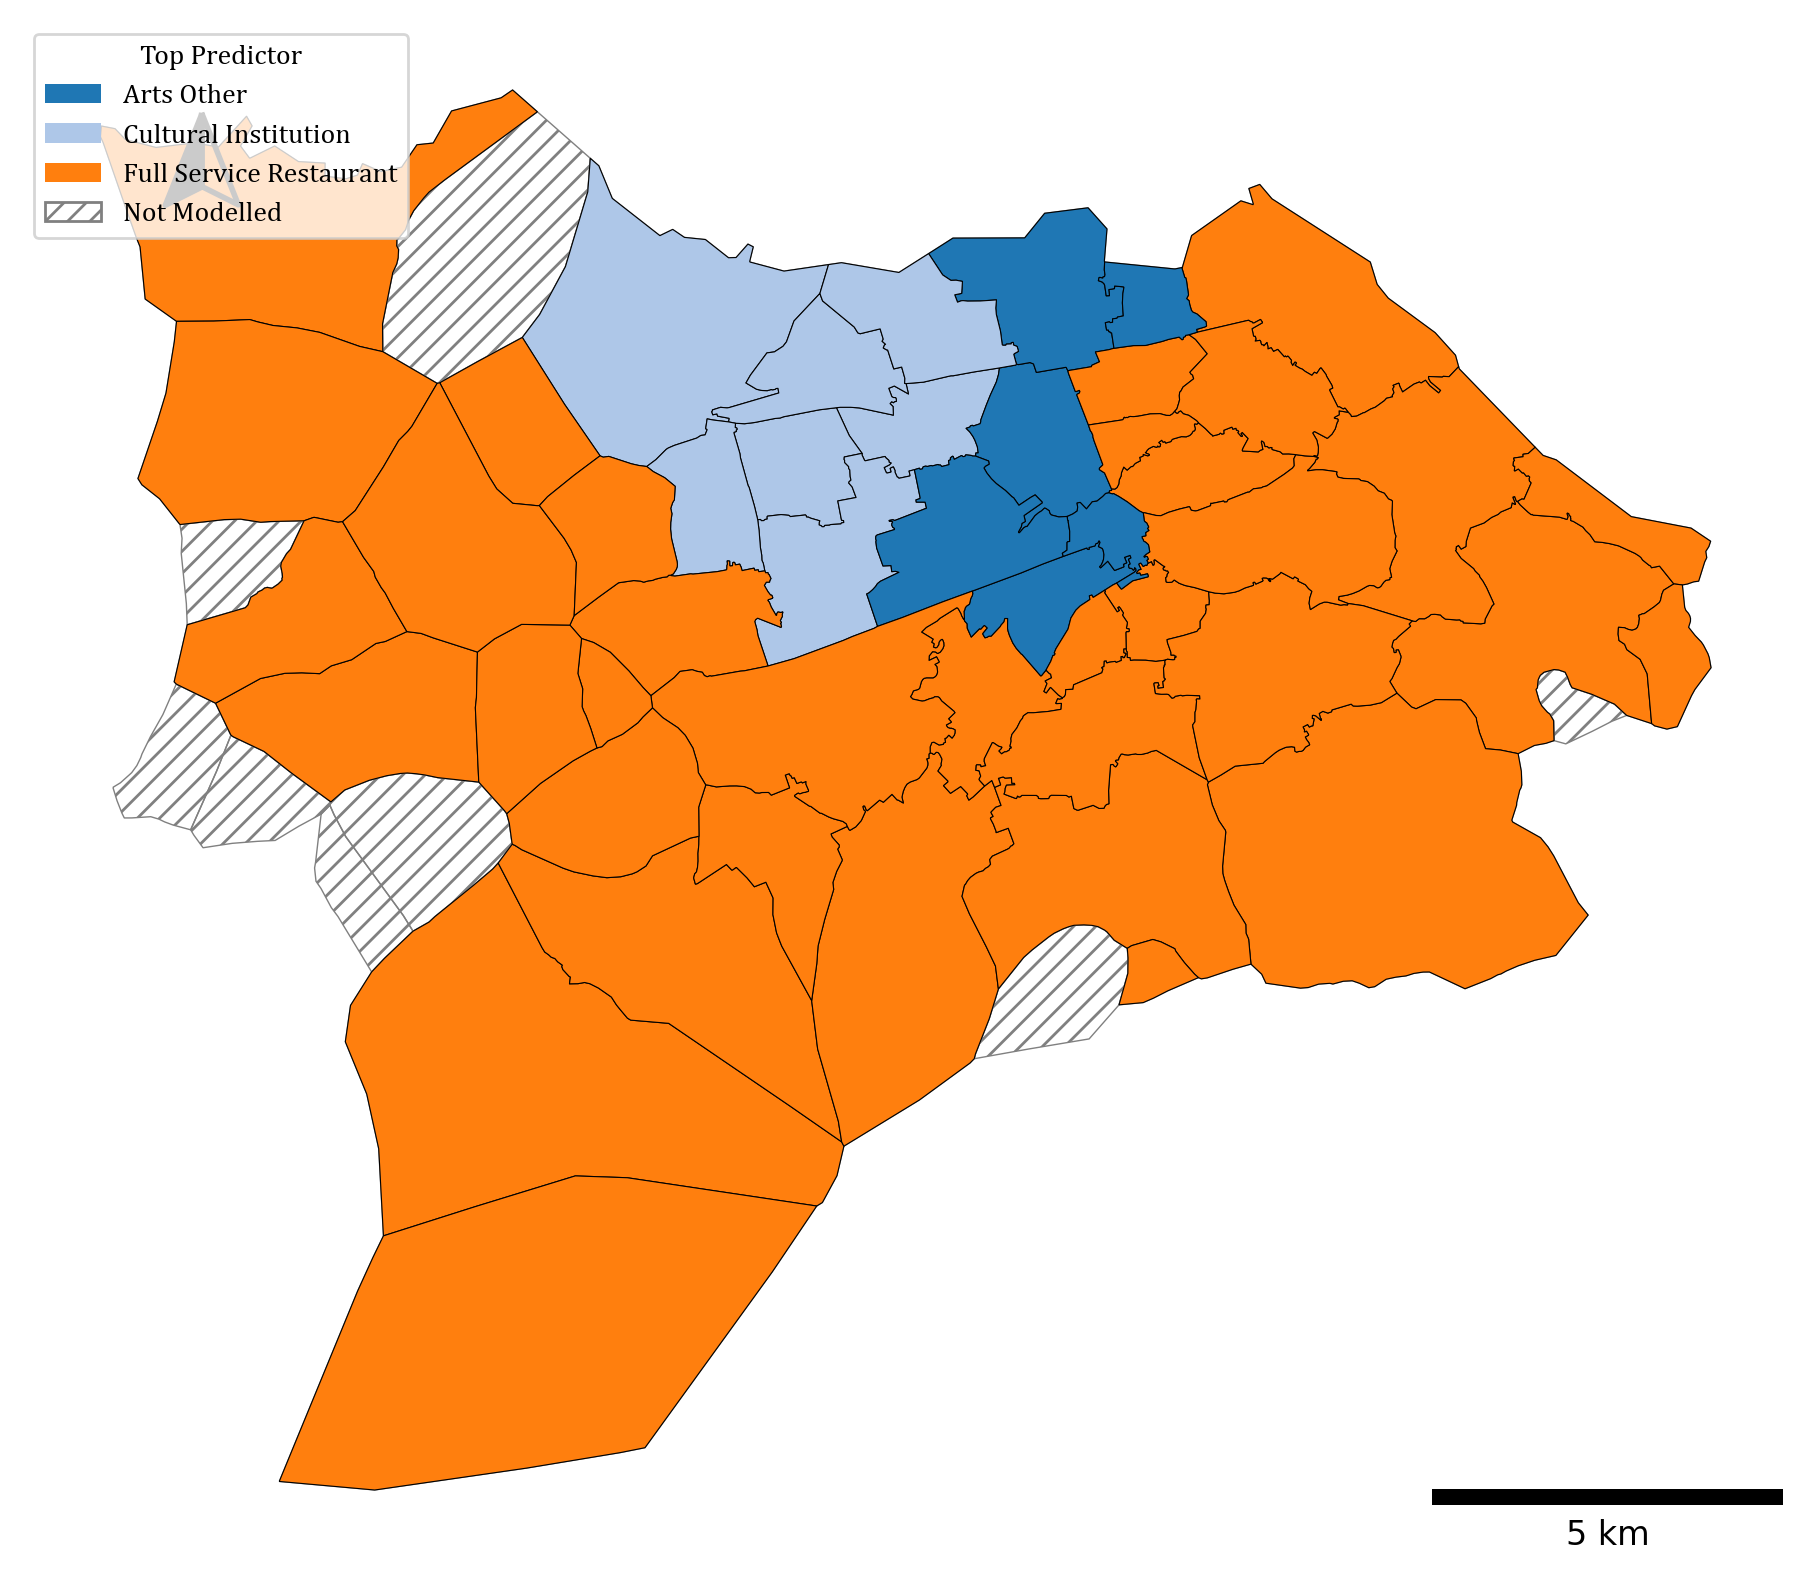

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns

# Get unique features and assign colors
top_features = edinburgh_airbnb_tourism_fs["gwrf_revenue_top_feature"].dropna().unique()
top_features.sort()  # for consistency

# Generate a color palette
palette = sns.color_palette("tab20", n_colors=len(top_features))
feature_colors = dict(zip(top_features, palette))

# Create the color map and norm
cmap = mcolors.ListedColormap([feature_colors[feat] for feat in top_features])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(top_features)+1)-0.5, ncolors=len(top_features))

# Map feature names to integer codes for plotting
edinburgh_airbnb_tourism_fs["feature_code"] = edinburgh_airbnb_tourism_fs["gwrf_revenue_top_feature"].map(
    {feat: i for i, feat in enumerate(top_features)}
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Baselayer (unmodelled areas)
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# Plot top features
mapped = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs["feature_code"].notna()].plot(
    column="feature_code",
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor="black",
    ax=ax,
    zorder=1
)

# Legend
legend_patches = [
    Patch(facecolor=feature_colors[feat], label=feat.replace("_log", "").replace("_density", "").replace("_", " ").title())
    for feat in top_features
]

# Add hatch legend
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
legend_patches.append(hatch_patch)

legend = ax.legend(
    handles=legend_patches,
    loc="upper left",
    title="Top Predictor",
    fontsize=11,
    title_fontproperties=cambria_prop,
    prop=cambria_prop
)

# Add north arrow and scale bar
add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)
scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# Title and layout
ax.axis("off")
plt.tight_layout()
plt.show()

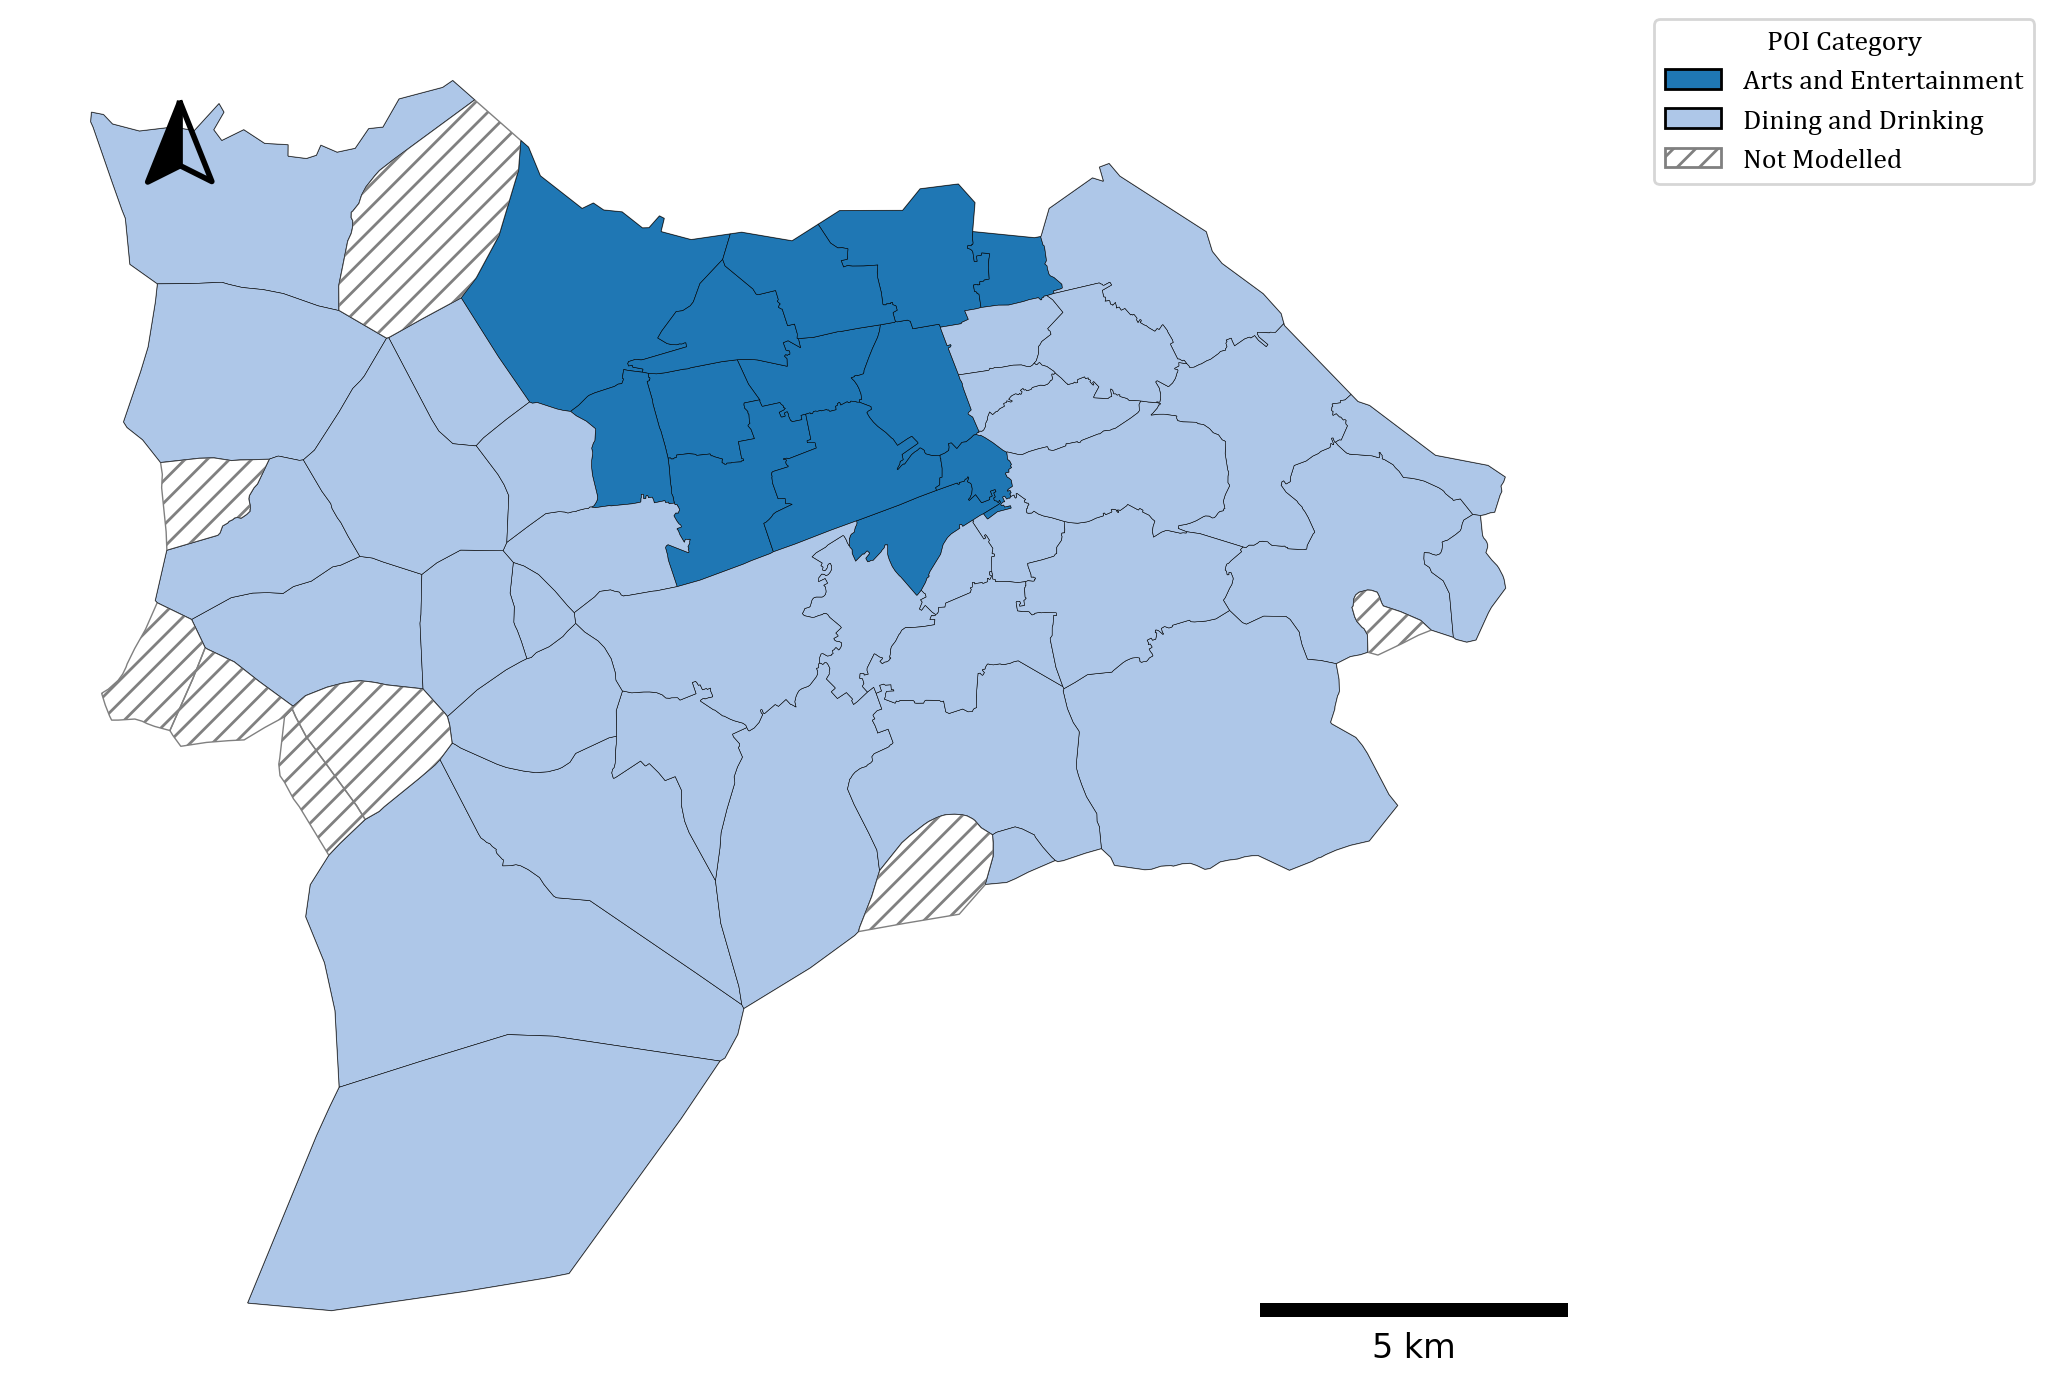

In [7]:
# Apply the mapping to create the new column
edinburgh_airbnb_tourism_fs["gwrf_revenue_top_feature_broad"] = edinburgh_airbnb_tourism_fs[
    "gwrf_revenue_top_feature"
].map(poi_group_map)

unique_pois = sorted(edinburgh_airbnb_tourism_fs["gwrf_revenue_top_feature_broad"].dropna().unique())
colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois):
    colors += colors  # extend if needed

poi_color_map = dict(zip(unique_pois, colors[:len(unique_pois)]))

# --- Step 4: Create figure and axis ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Step 5: Plot full Edinburgh shapefile as base (hatch for non-modeled) ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# --- Step 6: Plot colored GRF results ---
for poi, color in poi_color_map.items():
    subset = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs["gwrf_revenue_top_feature_broad"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# --- Step 7: Add legend ---
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]

# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# Add north arrow and scale bar
add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)
scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# --- Step 8: Finalize map ---
#plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Volume

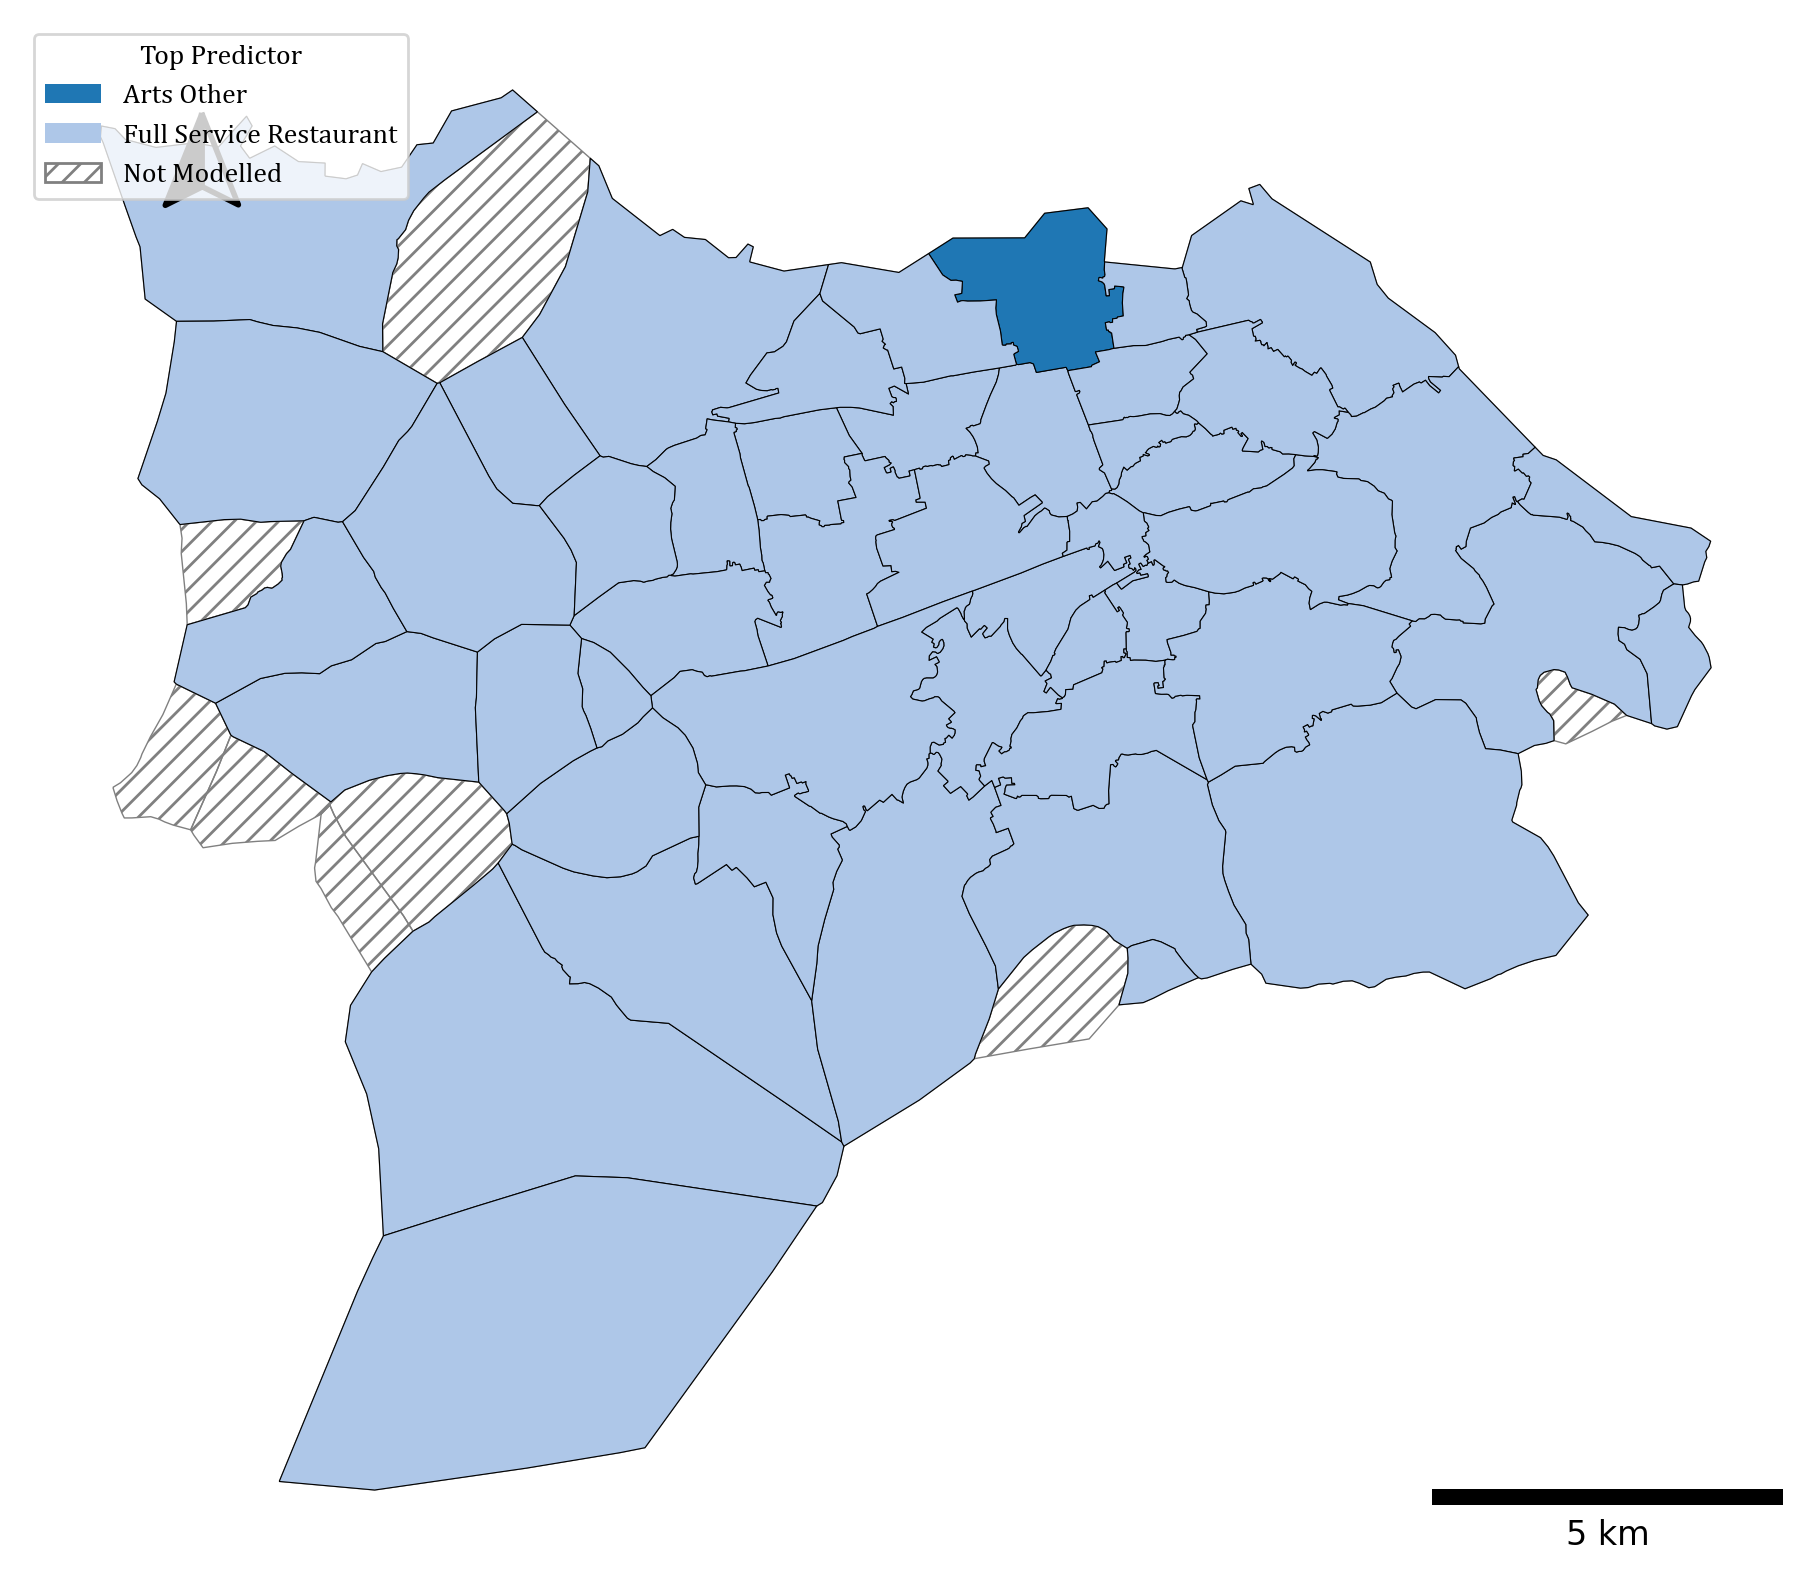

In [8]:
# Get unique features and assign colors
top_features = edinburgh_airbnb_tourism_fs["gwrf_volume_top_feature"].dropna().unique()
top_features.sort()  # for consistency

# Generate a color palette
palette = sns.color_palette("tab20", n_colors=len(top_features))
feature_colors = dict(zip(top_features, palette))

# Create the color map and norm
cmap = mcolors.ListedColormap([feature_colors[feat] for feat in top_features])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(top_features)+1)-0.5, ncolors=len(top_features))

# Map feature names to integer codes for plotting
edinburgh_airbnb_tourism_fs["feature_code"] = edinburgh_airbnb_tourism_fs["gwrf_volume_top_feature"].map(
    {feat: i for i, feat in enumerate(top_features)}
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Baselayer (unmodelled areas)
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# Plot top features
mapped = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs["feature_code"].notna()].plot(
    column="feature_code",
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor="black",
    ax=ax,
    zorder=1
)

# Legend
legend_patches = [
    Patch(facecolor=feature_colors[feat], label=feat.replace("_log", "").replace("_density", "").replace("_", " ").title())
    for feat in top_features
]

# Add hatch legend
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
legend_patches.append(hatch_patch)

legend = ax.legend(
    handles=legend_patches,
    loc="upper left",
    title="Top Predictor",
    fontsize=11,
    title_fontproperties=cambria_prop,
    prop=cambria_prop
)

# Add north arrow and scale bar
add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)
scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# Title and layout
ax.axis("off")
plt.tight_layout()
plt.show()

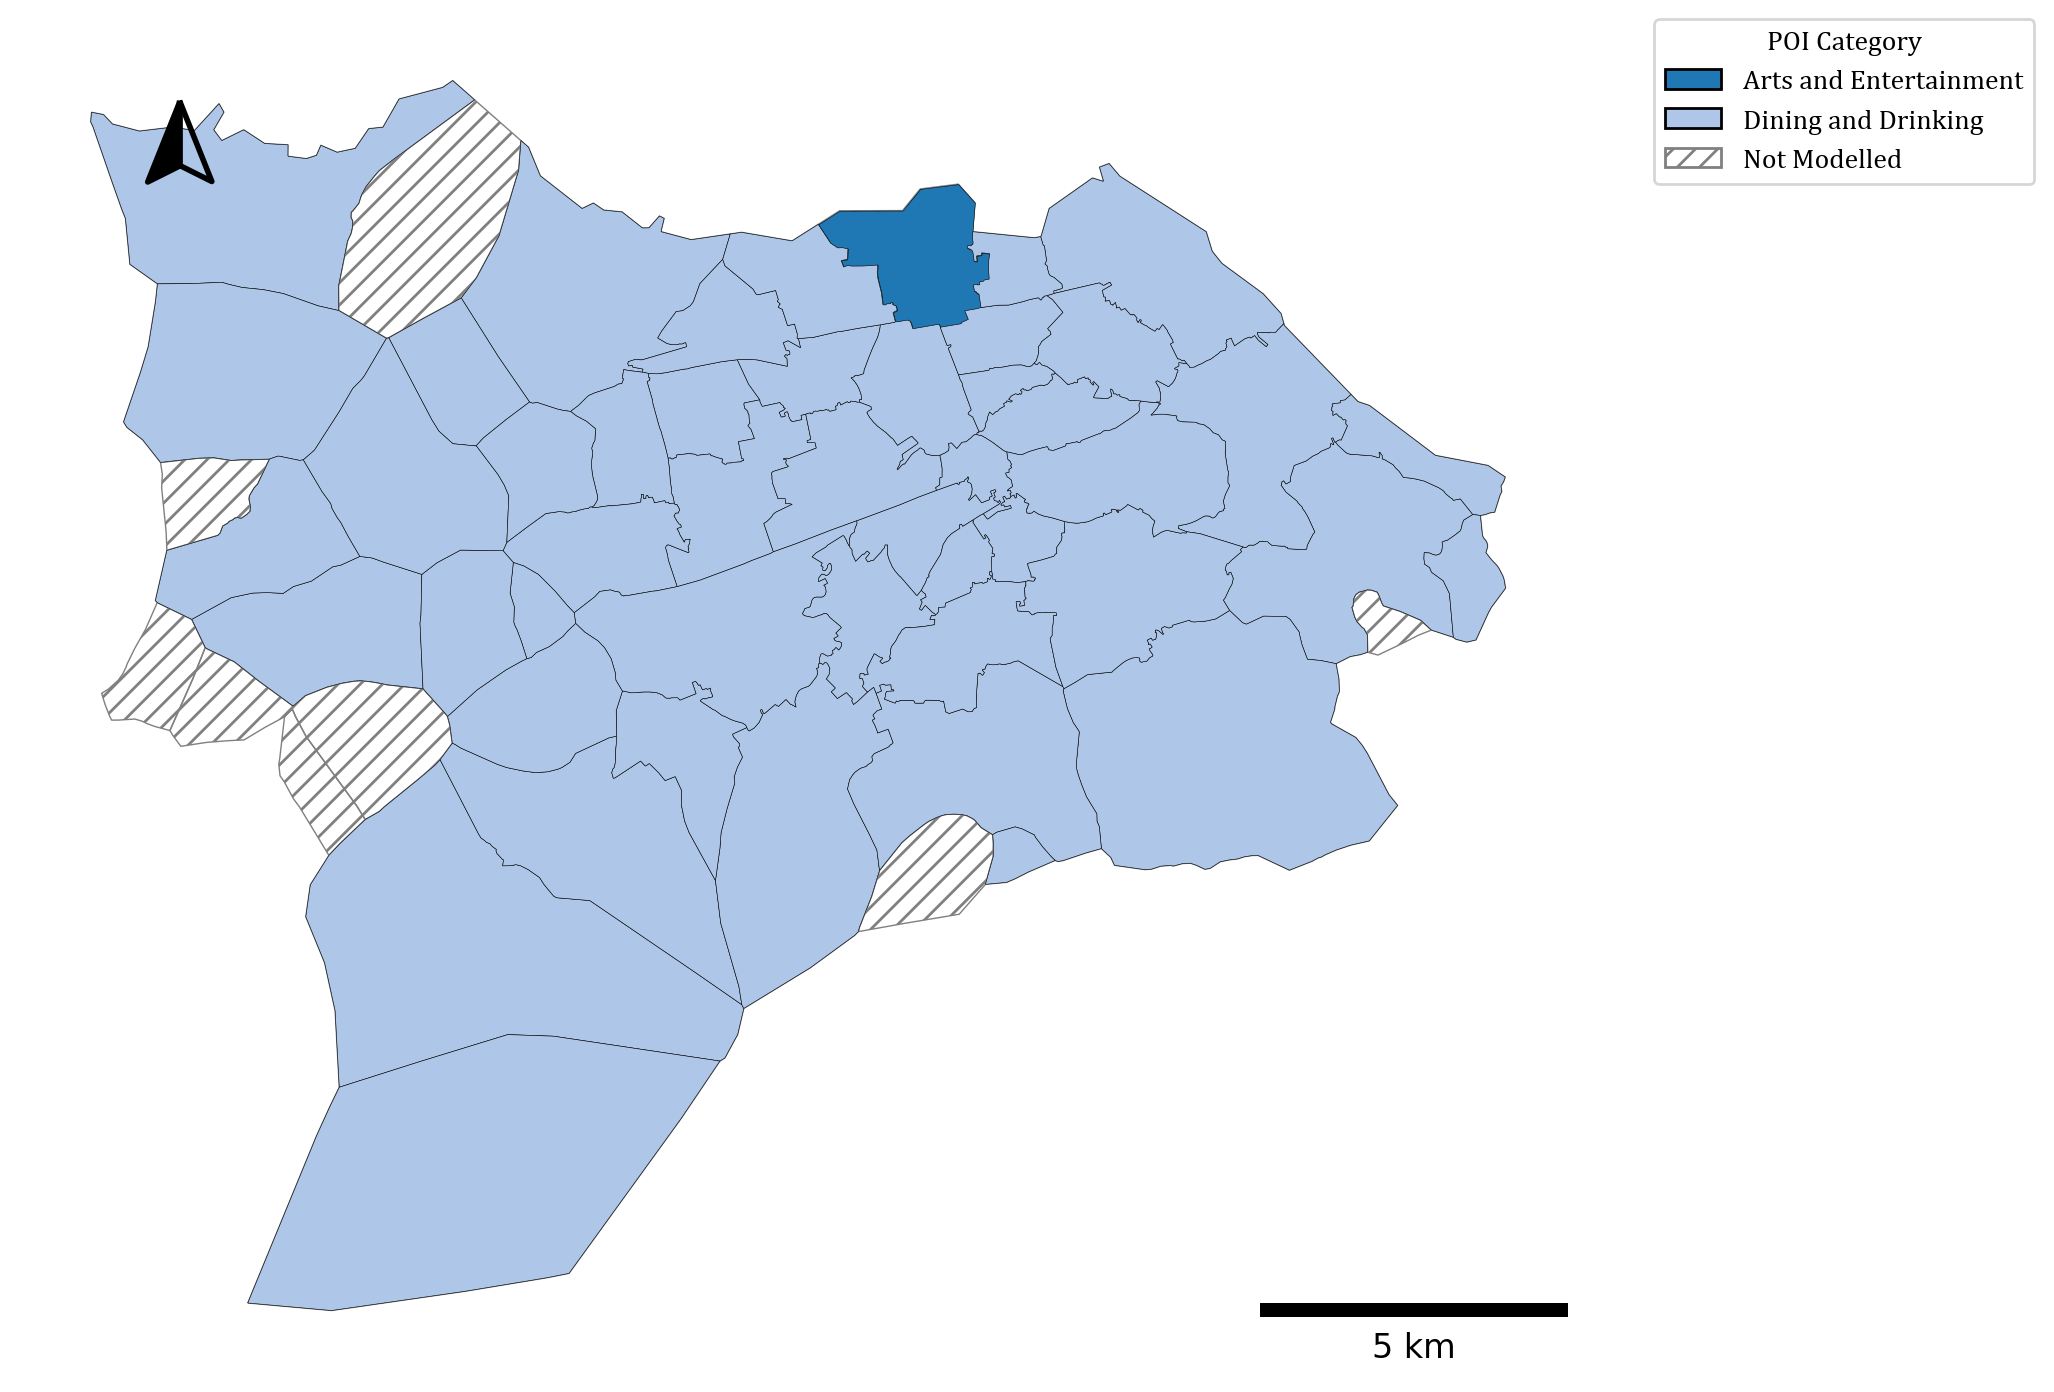

In [9]:
# Apply the mapping to create the new column
edinburgh_airbnb_tourism_fs["gwrf_volume_top_feature_broad"] = edinburgh_airbnb_tourism_fs[
    "gwrf_volume_top_feature"
].map(poi_group_map)

unique_pois = sorted(edinburgh_airbnb_tourism_fs["gwrf_volume_top_feature_broad"].dropna().unique())
colors = list(plt.cm.tab20.colors)
while len(colors) < len(unique_pois):
    colors += colors  # extend if needed

poi_color_map = dict(zip(unique_pois, colors[:len(unique_pois)]))

# --- Step 4: Create figure and axis ---
fig, ax = plt.subplots(figsize=(10, 8))

# --- Step 5: Plot full Edinburgh shapefile as base (hatch for non-modeled) ---
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch="///",
    linewidth=0.5,
    zorder=0
)

# --- Step 6: Plot colored GRF results ---
for poi, color in poi_color_map.items():
    subset = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs["gwrf_volume_top_feature_broad"] == poi]
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.2, zorder=1)

# --- Step 7: Add legend ---
legend_elements = [
    Patch(facecolor=poi_color_map[poi], edgecolor='black', label=poi)
    for poi in unique_pois
]

# Add legend entry for hatch
legend_elements.append(
    Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
)

legend = ax.legend(
    handles=legend_elements,
    title="POI Category",
    title_fontproperties=cambria_prop,
    prop=cambria_prop,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

# Add north arrow and scale bar
add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)
scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# --- Step 8: Finalize map ---
#plt.title("Top POI Importance per Location", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

### Density

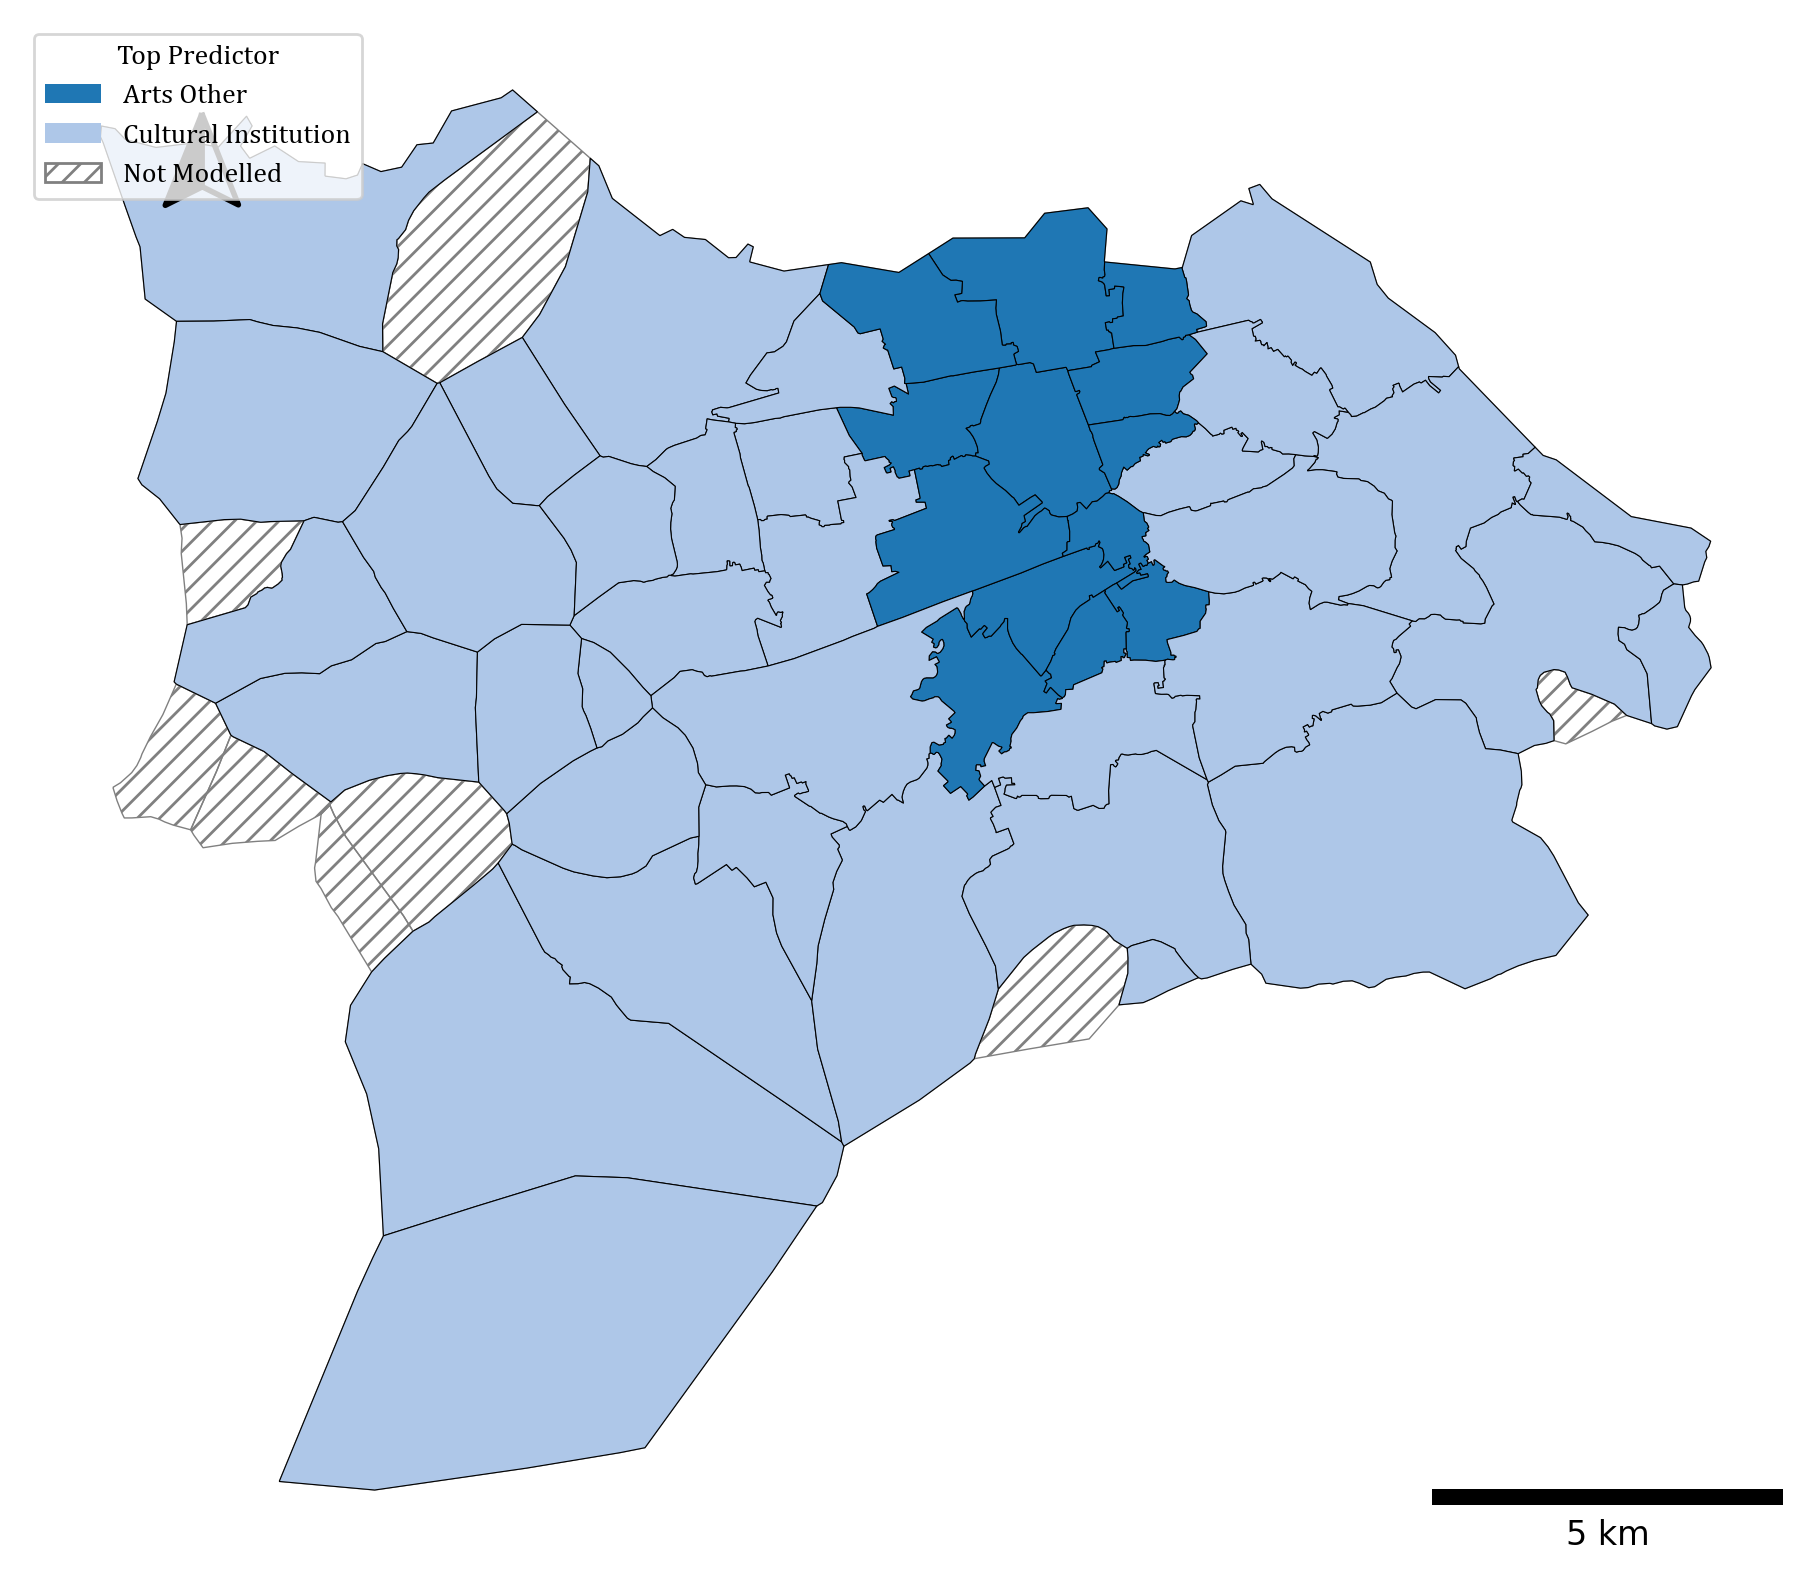

In [10]:
# Get unique features and assign colors
top_features = edinburgh_airbnb_tourism_fs["gwrf_density_top_feature"].dropna().unique()
top_features.sort()  # for consistency

# Generate a color palette
palette = sns.color_palette("tab20", n_colors=len(top_features))
feature_colors = dict(zip(top_features, palette))

# Create the color map and norm
cmap = mcolors.ListedColormap([feature_colors[feat] for feat in top_features])
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(top_features)+1)-0.5, ncolors=len(top_features))

# Map feature names to integer codes for plotting
edinburgh_airbnb_tourism_fs["feature_code"] = edinburgh_airbnb_tourism_fs["gwrf_density_top_feature"].map(
    {feat: i for i, feat in enumerate(top_features)}
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Baselayer (unmodelled areas)
edinburgh_glx.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    hatch='///',
    linewidth=0.5,
    zorder=0
)

# Plot top features
mapped = edinburgh_airbnb_tourism_fs[edinburgh_airbnb_tourism_fs["feature_code"].notna()].plot(
    column="feature_code",
    cmap=cmap,
    norm=norm,
    linewidth=0.4,
    edgecolor="black",
    ax=ax,
    zorder=1
)

# Legend
legend_patches = [
    Patch(facecolor=feature_colors[feat], label=feat.replace("_log", "").replace("_density", "").replace("_", " ").title())
    for feat in top_features
]

# Add hatch legend
hatch_patch = Patch(facecolor='white', edgecolor='gray', hatch='///', label='Not Modelled')
legend_patches.append(hatch_patch)

legend = ax.legend(
    handles=legend_patches,
    loc="upper left",
    title="Top Predictor",
    fontsize=11,
    title_fontproperties=cambria_prop,
    prop=cambria_prop
)

# Add north arrow and scale bar
add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.880, color='#000', text_scaler=0, text_yT=-1.25)
scalebar = ScaleBar(1, location="lower right", units="m", color="black", font_properties={"size": 12})
ax.add_artist(scalebar)

# Title and layout
ax.axis("off")
plt.tight_layout()
plt.show()